# Homework 7 Template

Rixin Li & G . Besla



In [80]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [69]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMassCode import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component

from GalaxyMass import ComponentMass


# M33AnalyticOrbit

In [82]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self,filename): # **** add inputs
        """ **** ADD COMMENTS """
        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.filename= filename+".txt"
        
        # **** create an instance of the  CenterOfMass class for M33 
        COM_33=CenterOfMass("M33_000.txt")
        # **** store the position VECTOR of the M33 COM (.value to get rid of units)

        self.r33=COM_33.COM_P(0.1)

        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)

        self.v33=COM_33.COM_V( self.r33[0], self.r33[1], self.r33[2])
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        COM_31=CenterOfMass("M31_000.txt")
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        self.r31=COM_31.COM_P(0.1)
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        
        self.v31=COM_31.COM_V( self.r31[0], self.r31[1], self.r31[2])
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        
        self.r0=(self.r33-self.r31).value
        self.v0=(self.v33-self.v31).value
        ### get the mass of each component in M31 
        ### disk
        self.rdisk = 5

        self.Mdisk= ComponentMass("M31_000.txt", 2)*1e12
        
        ### bulge
        self.rbulge =1 

        self.Mbulge=ComponentMass("M31_000.txt", 3)*1e12#Msun
        
        # Halo
        self.rhalo = 25 #kpc

        self.Mhalo=ComponentMass("M31_000.txt", 1)*1e12
     
    
    
    def HernquistAccel(self, M, r_a, r): # it is easiest if you take as an input the position VECTOR 
        """ **** ADD COMMENTS """
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(np.sum(r**2))
        
        ### *** Store the Acceleration
        Hern =  -self.G*M/(rmag *(r_a + rmag)**2) * r
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r):# it is easiest if you take as an input a position VECTOR  r 
        """ **** ADD COMMENTS """

        
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        R=np.sqrt(r[0]**2+r[1]**2)

        B=self.rdisk+np.sqrt(r[2]**2+(self.rdisk/5)**2)
        
        zcomp=np.array([1,1,B/np.sqrt(r[2]**2+(self.rdisk/5)**2)]) 
        # where ZSTUFF are the terms associated with the z direction
        
        Miya=-self.G*M/(R**2+B**2)**(1.5)*zcomp*r
       
        return Miya
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self,r): # input should include the position vector, r
        """ **** ADD COMMENTS """

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        Halo=self.HernquistAccel(self.Mhalo, self.rhalo, r)
        Bulge=self.HernquistAccel(self.Mbulge, self.rbulge, r)
        Disk=self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 

        Acc=Halo+Bulge+Disk
        return Acc
    
    
    
    def LeapFrog(self,dt,r,v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ **** ADD COMMENTS """
        
        # predict the position at the next half timestep
        rhalf = r+v*dt/2
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v+self.M31Accel(rhalf)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew =rhalf+vnew*dt/2
        
        return vnew, rnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ **** ADD COMMENTS """

        # initialize the time to the input starting time
        t = np.arange(t0,tmax+0.01,dt)
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((len(t),7))
        
        # initialize the first row of the orbit
        #orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        orbit[0,:] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (i<len(t)):  # as long as t has not exceeded the maximal time 

            # **** advance the time by one timestep, dt
           
            # **** store the new time in the first column of the ith row
            orbit[i,0] = t[i]
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            
            pos, vel = self.LeapFrog(dt,orbit[i-1,1:4],orbit[i-1,4:7])
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            
            orbit[i,1:4]=pos
            orbit[i,4:7]=vel;
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i+=1
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        
        

In [84]:
A=M33AnalyticOrbit('M33AnalyticOrbit')

In [85]:
A.OrbitIntegration( 0, 0.1, 10)

In [132]:
Sim33=np.genfromtxt('Orbit_M33.txt',skip_header=0)
Sim31=np.genfromtxt('Orbit_M31.txt',skip_header=0)
Analy33=np.genfromtxt('M33AnalyticOrbit.txt',skip_header=0)

In [134]:
SimRMag=np.sqrt(np.sum((Sim33[:,1:4]-Sim31[:,1:4])**2,axis=1))
AnaRMag=np.sqrt(np.sum(Analy33[:,1:4]**2,axis=1))

SimVMag=np.sqrt(np.sum(Sim33[:,4:7]**2,axis=1))
AnaVMag=np.sqrt(np.sum(Analy33[:,4:7]**2,axis=1))

timeS=Sim33[:,0]
timeA=Analy33[:,0]

In [136]:
print(AnaRMag[0])
print(timeA[0])

201.11976059054962
0.0


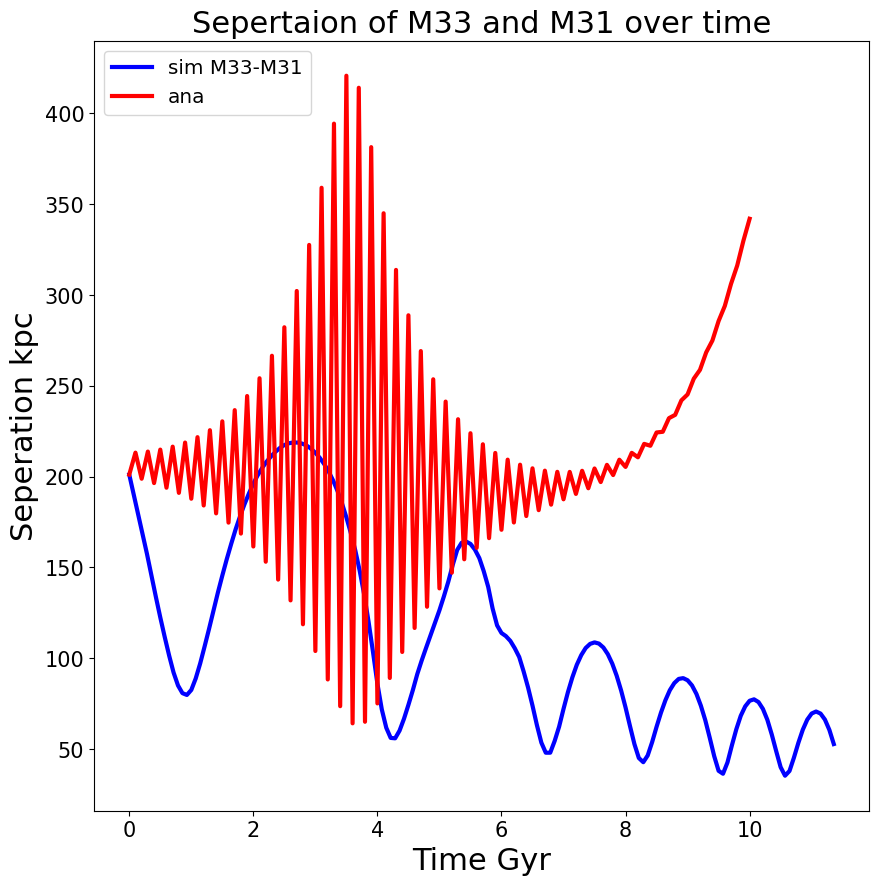

In [140]:
# Plot the Orbit of the galaxies 
#################################

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plotting time vs. Difference in seperation
plt.plot(timeS, SimRMag, color='blue', 
         linewidth=3, label='sim M33-M31')
plt.plot(timeA, AnaRMag, color='red', 
         linewidth=3, label='ana')

# Add axis labels
plt.xlabel('Time Gyr', fontsize=22)
plt.ylabel('Seperation kpc', fontsize=22)


#adjust tick label font size
label_size = 15
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize='x-large')

#add figure text
plt.title( 'Sepertaion of M33 and M31 over time', fontsize=22)

plt.show()